# <b style="color:#FF5800"> Amazon Fine Food Reviews Analysis Data Cleaning and Pre-Processing.

<img style="width:800px;" src=".\EDA.png">

### Data preprocessing techniques: Cleaning, handling missing values, and text preprocessing.

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline


In [88]:
import pandas as pd
reviews = pd.read_csv("C:/Users/antonio.eliso/Desktop/AI Engineer Academy/03. Week 3/Day 4/CapstoneProject/Data/Reviews.csv")
reviews


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


In [89]:

reviews.describe().round(2)

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.00,568454.00,568454.00,568454.00,5.684540e+05
mean,284227.50,1.74,2.23,4.18,1.296257e+09
std,164098.68,7.64,8.29,1.31,4.804331e+07
min,1.00,0.00,0.00,1.00,9.393408e+08
25%,142114.25,0.00,0.00,4.00,1.271290e+09
50%,284227.50,0.00,1.00,5.00,1.311120e+09
75%,426340.75,2.00,2.00,5.00,1.332720e+09
max,568454.00,866.00,923.00,5.00,1.351210e+09


### Get information about the number of data points in the dataset

In [90]:
print("Number of datapoints: ",reviews.shape[0])
print("Number of features: ",reviews.shape[1])

Number of datapoints:  568454
Number of features:  10


### Number of reviews corresponding to each of the ratings.

C:\Users\antonio.eliso\AppData\Local\Temp\ipykernel_23616\2914634219.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x= 'Score', data=reviews, palette='gist_rainbow')


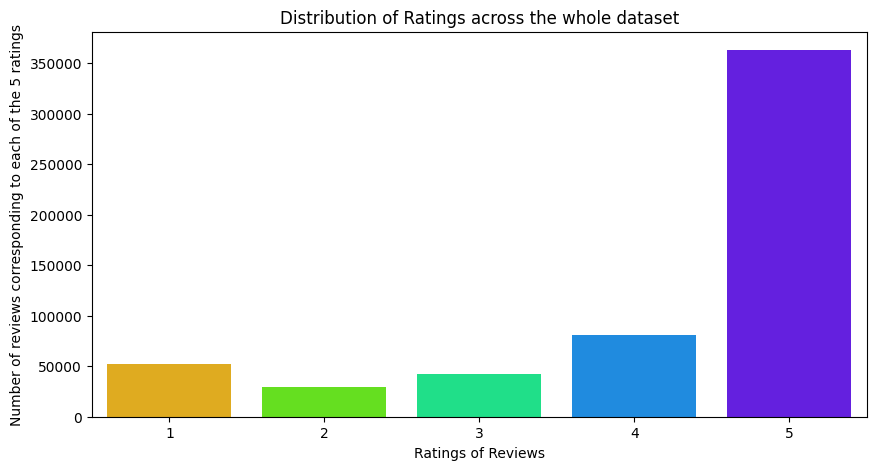

Score
5    363122
4     80655
1     52268
3     42640
2     29769
Name: count, dtype: int64


In [91]:
plt.figure(figsize=(10,5))
sns.countplot(x= 'Score', data=reviews, palette='gist_rainbow')
plt.title("Distribution of Ratings across the whole dataset")
plt.xlabel("Ratings of Reviews")
plt.ylabel("Number of reviews corresponding to each of the 5 ratings")
plt.show()
print(reviews['Score'].value_counts())

## 2. Using the review text data and perform Natural Language Processing (NLP) tasks.

In [92]:
reviews['SentimentPolarity'] = reviews['Score'].apply(lambda x : 'Positive' if x > 3 else 'Negative')
reviews['Class_Labels'] = reviews['SentimentPolarity'].apply(lambda x : 1 if x == 'Positive' else 0)
reviews = reviews[reviews['Score']!= 3]

In [93]:
reviews.duplicated(subset={"UserId", "ProfileName", "Time", "Text"}).value_counts()

False    364173
True     161641
Name: count, dtype: int64

In [94]:
reviews = reviews.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print("The shape of the data matrix after deduplication, Stage 1: {}".format(reviews.shape))



The shape of the data matrix after deduplication, Stage 1: (364173, 12)


In [95]:
import numpy as np
print("How much percentage of data still remains: ", round(reviews.shape[0]*100/568454, 2),"%")

How much percentage of data still remains:  64.06 %


C:\Users\antonio.eliso\AppData\Local\Temp\ipykernel_23616\2888307924.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Score',data=reviews, palette='gist_rainbow')


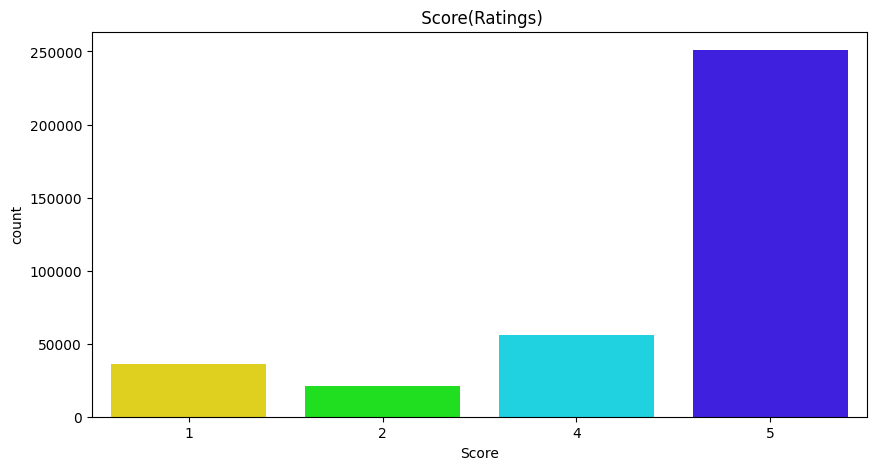

Score
5    250964
4     56099
1     36306
2     20804
Name: count, dtype: int64


In [96]:
plt.figure(figsize=(10,5))
sns.countplot(x='Score',data=reviews, palette='gist_rainbow')
plt.title(' Score(Ratings)')
plt.show()
print(reviews['Score'].value_counts())

In [97]:
reviews=reviews[reviews.HelpfulnessNumerator <= reviews.HelpfulnessDenominator]


In [98]:
print("Number of reviews which does not have any upvote: ",reviews[reviews.HelpfulnessDenominator==0].shape[0])

Number of reviews which does not have any upvote:  171507


In [99]:
print("Total number of unique users: ",len(set(list(reviews.UserId))))
print("Total number of unique products: ",len(set(list(reviews.ProductId))))

Total number of unique users:  243414
Total number of unique products:  65501


#### <b>Text Preprocessing

In [100]:
#Import 
import re
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

#Function to clean html tags from a sentence
def removeHtml(sentence): 
    pattern = re.compile('<.*?>')
    cleaned_text = re.sub(pattern,' ',sentence)
    return cleaned_text

#Function to keep only words containing letters A-Z and a-z. This will remove all punctuations, special characters etc. https://stackoverflow.com/a/5843547/4084039
def removePunctuations(sentence):
    cleaned_text  = re.sub('[^a-zA-Z]',' ',sentence)
    return (cleaned_text)

#Remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
def removeNumbers(sentence):
    sentence = re.sub("\S*\d\S*", " ", sentence).strip()
    return (sentence)

#Remove URL from sentences.
def removeURL(sentence):
    text = re.sub(r"http\S+", " ", sentence)
    sentence = re.sub(r"www.\S+", " ", text)
    return (sentence)

#We will remove all such words which has three consecutive repeating characters.
def removePatterns(sentence): 
    cleaned_text  = re.sub("\\s*\\b(?=\\w*(\\w)\\1{2,})\\w*\\b",' ',sentence)
    return (cleaned_text)

#Expand the reviews x is aninput string of any length. Convert all the words to lower case
def decontracted(x):
    x = str(x).lower()
    x = x.replace(",000,000", " m").replace(",000", " k").replace("′", "'").replace("’", "'")\
                           .replace("won't", " will not").replace("cannot", " can not").replace("can't", " can not")\
                           .replace("n't", " not").replace("what's", " what is").replace("it's", " it is")\
                           .replace("'ve", " have").replace("'m", " am").replace("'re", " are")\
                           .replace("he's", " he is").replace("she's", " she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will").replace("how's"," how has").replace("y'all"," you all")\
                           .replace("o'clock"," of the clock").replace("ne'er"," never").replace("let's"," let us")\
                           .replace("finna"," fixing to").replace("gonna"," going to").replace("gimme"," give me").replace("gotta"," got to").replace("'d"," would")\
                           .replace("daresn't"," dare not").replace("dasn't"," dare not").replace("e'er"," ever").replace("everyone's"," everyone is")\
                           .replace("'cause'"," because")
    
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    return x

#Stemming and stopwords removal
snow = SnowballStemmer('english') #initialising the snowball stemmer
#Removing the word 'not' from stopwords
default_stopwords = set(stopwords.words('english'))
#excluding some useful words from stop words list as we doing sentiment analysis
excluding = set(['against','not','don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
             'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 
             'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't",'shouldn', "shouldn't", 'wasn',
             "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"])
custom_stopwords = default_stopwords - excluding

  0%|          | 0/364171 [00:00<?, ?it/s]

100%|██████████| 70255/70255 [00:00<00:00, 2248262.92it/s]


Text(0, 0.5, 'Number of Words')

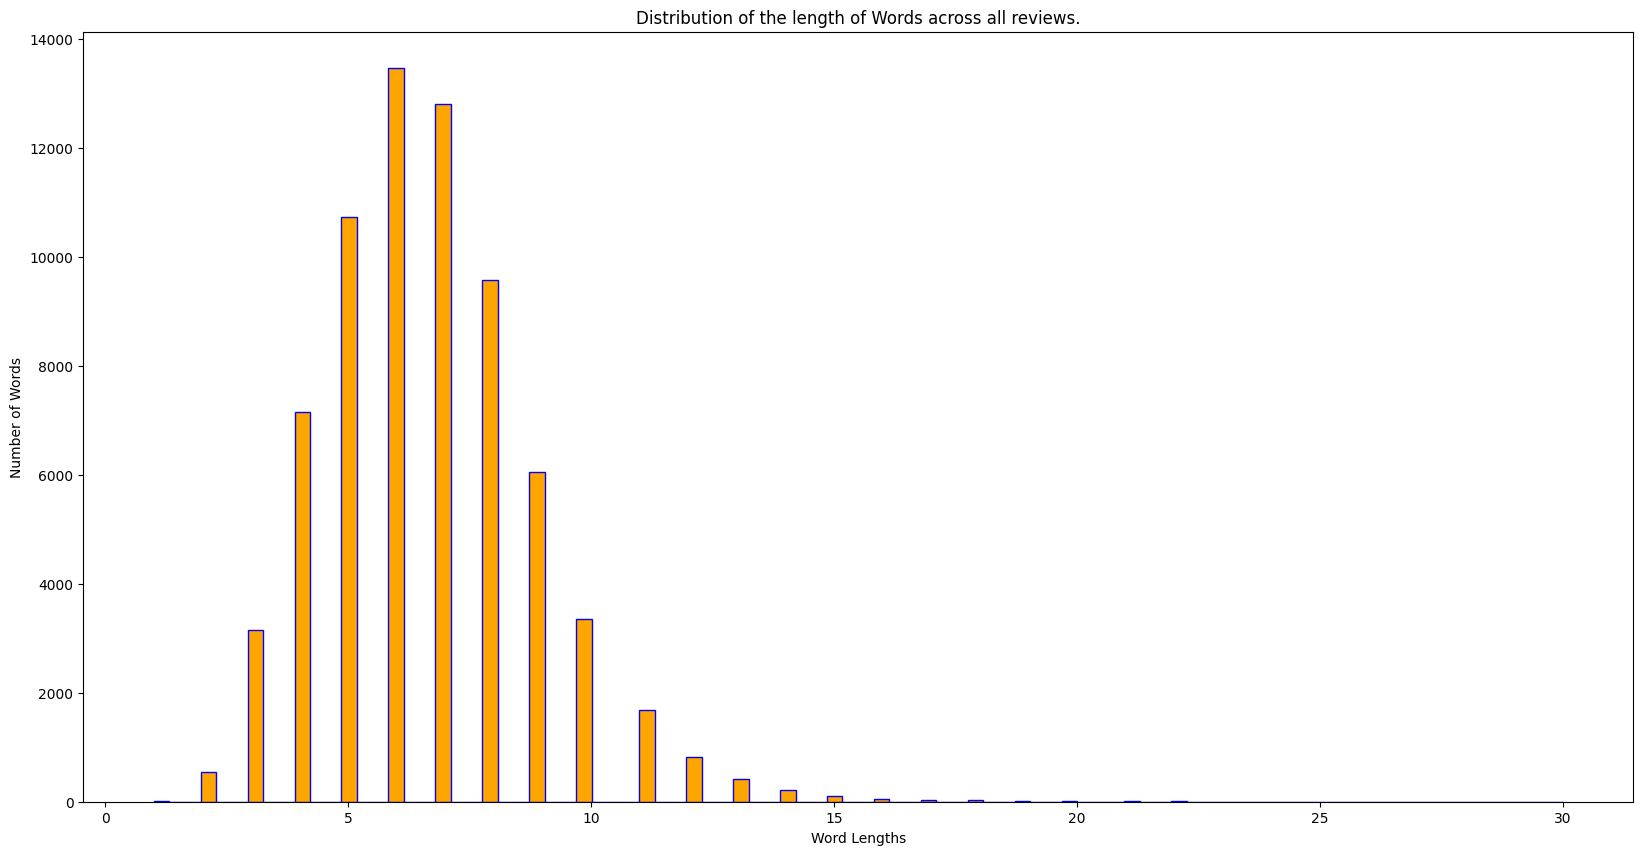

In [109]:
#We will check the distribution of stemmed word lengths across the whole review dataset to understand what is the length of the maximum number of words we will consider for the word to be relevant.
#In other words we will keep only those words which has a length less than that of a speicific length (we will obtain this specific length from the histogram).
from tqdm import tqdm
total_words = []

for review in tqdm(reviews['Text'].values):
    filtered_sentence=[]
    review = decontracted(review)
    review = removeNumbers(review)
    review = removeHtml(review)
    review = removeURL(review)
    review = removePunctuations(review)
    review = removePatterns(review)
    
    for cleaned_words in review.split():   
        if((cleaned_words not in custom_stopwords)):          
            stemed_word=(snow.stem(cleaned_words.lower()))
            total_words.append(stemed_word)

total_words = list(set(total_words)) #Get list of unique words.

#A list to hold the length of each words used in all the reviews used across the whole dataset.
dist = []
for i in tqdm(total_words):
    length = len(i)
    dist.append(length)

# matplotlib histogram to see the distribution of the length of words
plt.figure(figsize=(20,10))
plt.hist(dist, color = 'orange', edgecolor = 'blue', bins =90)
plt.title('Distribution of the length of Words across all reviews.')
plt.xlabel('Word Lengths')
plt.ylabel('Number of Words')

In [105]:
# Combining all the above data cleaning methodologies as discussed above.

#Processing review Texts
preprocessed_reviews = [] #Store all the processed reviews
all_positive_words=[] #Store all the relevant words from Positive reviews
all_negative_words=[] #Store all the relevant words from Negative reviews
 
count=0     #Iterator to iterate through the list of reviews and check if a given review belongs to the positive or negative class
string=' '    
stemed_word=' '

for review in tqdm(reviews['Text'].values):
    filtered_sentence=[]
    review = decontracted(review)
    review = removeNumbers(review)
    review = removeHtml(review)
    review = removeURL(review)
    review = removePunctuations(review)
    review = removePatterns(review)
    
    for cleaned_words in review.split():   
        if((cleaned_words not in custom_stopwords) and (2<len(cleaned_words)<16)):
            stemed_word=(snow.stem(cleaned_words.lower()))                                   
            filtered_sentence.append(stemed_word)
            if (reviews['SentimentPolarity'].values)[count] == 'Positive': 
                all_positive_words.append(stemed_word) #List of all the relevant words from Positive reviews
            if(reviews['SentimentPolarity'].values)[count] == 'Negative':
                all_negative_words.append(stemed_word) #List of all the relevant words from Negative reviews
        else:
            continue
    review = " ".join(filtered_sentence) #Final string of cleaned words    
    preprocessed_reviews.append(review.strip()) #Data corpus contaning cleaned reviews from the whole dataset
    count+=1
#Adding a column of CleanedText to the table final which stores the data_corpus after pre-processing the reviews 
reviews['CleanedText']=preprocessed_reviews 
    
print("The length of the data corpus is : {}".format(len(preprocessed_reviews)))

  0%|          | 0/364171 [00:00<?, ?it/s]

100%|██████████| 364171/364171 [13:09<00:00, 461.15it/s] 

The length of the data corpus is : 364171


In [106]:
from collections import Counter
print("No. of positive words:",len(all_positive_words))
print("No. of negative words:",len(all_negative_words))
# print("Sample postive words",all_positive_words[:9])
# print("Sample negative words",all_negative_words[:9])
positive = Counter(all_positive_words)
print("\nMost Common postive words",positive.most_common(10))
negative = Counter(all_negative_words)
print("\nMost Common negative words",negative.most_common(10))

No. of positive words: 11790862
No. of negative words: 2426280

Most Common postive words [('not', 292389), ('like', 140357), ('tast', 130615), ('good', 113380), ('flavor', 110911), ('love', 107545), ('great', 104300), ('use', 103673), ('one', 97178), ('product', 91900)]

Most Common negative words [('not', 95184), ('tast', 35016), ('like', 32598), ('product', 28579), ('would', 23275), ('one', 20699), ('flavor', 19860), ('tri', 17741), ('use', 15273), ('good', 15116)]


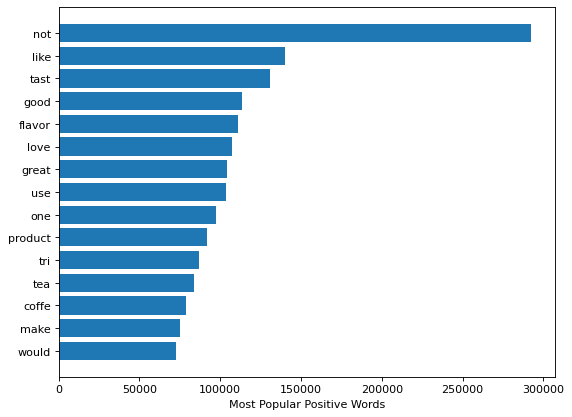

In [107]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
pos_words = positive.most_common(15)
pos_words.sort(key=lambda x: x[1], reverse=False) 
words=[]
times=[]
for w,t in pos_words:
    words.append(w)
    times.append(t)
plt.barh(range(len(words)),times)
plt.yticks(range(len(words)),words) 
plt.xlabel('Most Popular Positive Words')
plt.show()

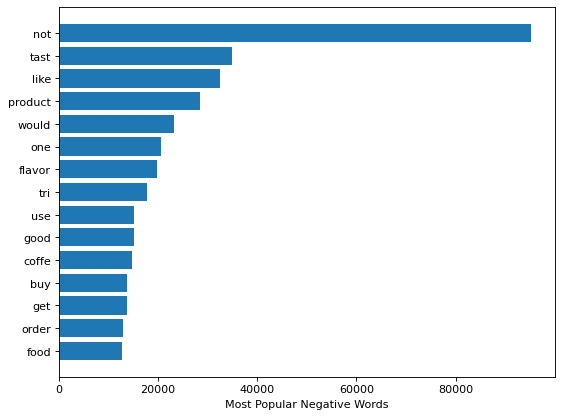

In [108]:
neg_words = negative.most_common(15)
neg_words.sort(key=lambda x: x[1], reverse=False) 
words=[]
times=[]
for w,t in neg_words:
    words.append(w)
    times.append(t)
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.barh(range(len(words)),times)
plt.yticks(range(len(words)),words) 
plt.xlabel('Most Popular Negative Words')
plt.show()

In [111]:
from sklearn.feature_extraction.text import CountVectorizer
df2=reviews
uni_gram = CountVectorizer() #in scikit-learn
uni_gram_vectors = uni_gram.fit_transform(df2['CleanedText'].values)